In [1]:
!pip install -qq transformers
!pip install -qq sentencepiece
!pip install -qq datasets


     |████████████████████████████████| 3.5 MB 14.0 MB/s 
     |████████████████████████████████| 6.8 MB 74.1 MB/s 
     |████████████████████████████████| 596 kB 71.9 MB/s 
     |████████████████████████████████| 895 kB 76.1 MB/s 
     |████████████████████████████████| 67 kB 4.9 MB/s 
     |████████████████████████████████| 1.2 MB 13.6 MB/s 
     |████████████████████████████████| 311 kB 13.5 MB/s 
     |████████████████████████████████| 1.1 MB 70.1 MB/s 
     |████████████████████████████████| 133 kB 72.3 MB/s 
     |████████████████████████████████| 243 kB 86.2 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
     |████████████████████████████████| 144 kB 86.6 MB/s 
     |████████████████████████████████| 271 kB 89.9 MB/s 


In [2]:
import transformers
import datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup,Trainer, TrainingArguments
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
import random
from textwrap import wrap
from datetime import datetime
from datasets import load_from_disk
from datasets import Dataset
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [3]:
from torch import nn

In [4]:
# the model we gonna train, base uncased BERT
# check text classification models here: https://huggingface.co/models?filter=text-classification
MODEL_NAME = "distilbert-base-uncased"
# max sequence length for each document/sentence sample
BATCH_SIZE = 128
EVAL_BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE= 10.58e-5
WEIGHT_DECAY =  0.103
WARMUP_STEPS = 449
RANDOM_SEED=22

LEARNING_RATE_DECAY_MULTIPLIER = 0.95
REINIT_LAYERS = 2

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
class LLRDTrainer(Trainer):

    def create_optimizer_and_scheduler(self, num_training_steps: int):
        """
        Setup the optimizer and the learning rate scheduler.
        We provide a reasonable default that works well. If you want to use something else, you can pass a tuple in the
        Trainer's init through `optimizers`, or subclass and override this method (or `create_optimizer` and/or
        `create_scheduler`) in a subclass.
        """
        self.create_optimizer()
        parameters = get_optimizer_parameters_with_llrd(self.model, LEARNING_RATE, 0.95)
        self.optimizer = AdamW(parameters, lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)
        self.create_scheduler(num_training_steps=num_training_steps, optimizer=self.optimizer)


def set_seed(seed):
    """Set all seeds to make results reproducible (deterministic mode).
       When seed is None, disables deterministic mode.
    :param seed: an integer to your choosing
    """
    if seed is not None:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(seed)
        random.seed(seed)

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
  acc = accuracy_score(labels, preds)
  confusion_matrix = classification_report(labels, preds, digits=4,output_dict=True)
  return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'hate_f1': confusion_matrix["0"]["f1-score"],
        'hate_recall': confusion_matrix["0"]["recall"],
        'hate_precision': confusion_matrix["0"]["precision"],
        'offensive_f1': confusion_matrix["1"]["f1-score"],
        'offensive_recall': confusion_matrix["1"]["recall"],
        'offensive_precision': confusion_matrix["1"]["precision"],
        'normal_f1': confusion_matrix["2"]["f1-score"],
        'normal_recall': confusion_matrix["2"]["recall"],
        'normal_precision': confusion_matrix["2"]["precision"],    
  }



def timestamp():
    dateTimeObj = datetime.now()
    timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S.%f)")
    print(timestampStr)


def get_optimizer_parameters_with_llrd(model, peak_lr, multiplicative_factor):
    num_encoder_layers = len(model.distilbert.transformer.layer)
    # Task specific layer gets the peak_lr
    tsl_parameters = [
        {
            "params": [param for name, param in model.named_parameters() if 'distilbert' not in name],
            "param_names": [name for name, param in model.named_parameters() if 'distilbert' not in name],
            "lr": peak_lr,
            "name": "tsl",
        }
    ]

    # Starting from the last encoder layer each encoder layers get a lr defined by
    # current_layer_lr = prev_layer_lr * multiplicative_factor
    # the last encoder layer lr = peak_lr * multiplicative_factor
    encoder_parameters = [
        {
            "params": [param for name, param in model.named_parameters() if f"distilbert.transformer.layer.{layer_num}" in name],
            "param_names": [name for name, param in model.named_parameters() if f"distilbert.transformer.layer.{layer_num}" in name],
            "lr": peak_lr * (multiplicative_factor ** (num_encoder_layers - layer_num)),
            "name": f"layer_{layer_num}",
        }
        for layer_num, layer in enumerate(model.distilbert.transformer.layer)
    ]

    # Embedding layer gets embedding layer lr = first encoder layer lr * multiplicative_factor
    embedding_parameters = [
        {
            "params": [param for name, param in model.named_parameters() if 'embeddings' in name],
            "param_names": [name for name, param in model.named_parameters() if 'embeddings' in name],
            "lr": peak_lr * (multiplicative_factor ** (num_encoder_layers + 1)),
            "name": "embedding",
        }
    ]
    return tsl_parameters + encoder_parameters + embedding_parameters


def reinit_autoencoder_model(model, reinit_num_layers=0):
    """reinitialize autoencoder model layers"""

    if reinit_num_layers:
        for layer in model.distilbert.transformer.layer[-reinit_num_layers:]:
            for module in layer.modules():
                if isinstance(module, nn.Embedding):
                  if module.weight.requires_grad:
                    module.weight.data.normal_(mean=0.0, std=model.config.initializer_range)
                if isinstance(module, nn.Linear):
                  module.weight.data.normal_(mean=0.0, std=model.config.initializer_range)
                elif isinstance(module, nn.LayerNorm):
                  module.bias.data.zero_()
                  module.weight.data.fill_(1.0)
                if isinstance(module, nn.Linear) and module.bias is not None:
                  module.bias.data.zero_()

    return model


def model_init():
    temp_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=3).to(device)
    return temp_model


In [6]:
set_seed(RANDOM_SEED)


In [7]:
result_list = []
for i in range(1,11):

  training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/'+str(i),          # output directory
    num_train_epochs=EPOCHS,              # total number of training epochs
    save_strategy ="epoch" ,
    per_device_train_batch_size=BATCH_SIZE,  # batch size per device during training
    per_device_eval_batch_size=EVAL_BATCH_SIZE ,   # batch size for evaluation
    weight_decay= WEIGHT_DECAY,               # strength of weight decay
    learning_rate= LEARNING_RATE, 
    warmup_steps = WARMUP_STEPS,
    logging_dir='./disbert_hate_optimal/logs',     # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    evaluation_strategy="epoch",
  )

  hatetwit_dataset_dfs = load_from_disk('/content/drive/MyDrive/Dissertation/datasets/hatetwit_'+str(i))
  train_dataset = hatetwit_dataset_dfs ["train"].remove_columns(["input_ids_bert","attention_mask_bert","token_type_ids_bert"])
  eval_dataset = hatetwit_dataset_dfs ["validation"].remove_columns(["input_ids_bert","attention_mask_bert","token_type_ids_bert"])
  test_dataset = hatetwit_dataset_dfs ["test"].remove_columns(["input_ids_bert","attention_mask_bert","token_type_ids_bert"])
  model = model_init()
  parameters = get_optimizer_parameters_with_llrd(model, LEARNING_RATE, 0.95)
  trainer = Trainer(
      model=model,                         # the instantiated Transformers model to be trained
      args=training_args,                  # training arguments, defined above
      train_dataset= train_dataset,         # training dataset
      eval_dataset=eval_dataset,          # evaluation dataset
      compute_metrics=compute_metrics,     # the callback that computes metrics of interest
  )
  trainer.create_optimizer()
  trainer.optimizer = AdamW(parameters, lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)
  trainer.train()
  trainer.save_model('/content/drive/MyDrive/Dissertation/disbert_hate_optimal/models/model_'+str(i))
  results = trainer.evaluate(test_dataset)
  results["model_run"] = i
  result_list.append(results)
  print(timestamp())

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,No log,0.573734,0.764971,0.718765,0.715898,0.721846,0.695869,0.703219,0.688670,0.846139,0.837838,0.854607,0.614286,0.624481,0.604418
2,0.647900,0.495317,0.801889,0.750979,0.767162,0.744156,0.762228,0.791751,0.734827,0.872505,0.898186,0.848252,0.618203,0.542531,0.718407
3,0.647900,0.486810,0.808328,0.765058,0.767075,0.765991,0.784652,0.822938,0.749771,0.875161,0.878563,0.871785,0.635359,0.596473,0.679669


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/1/checkpoint-292
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/1/checkpoint-292/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/1/checkpoint-292/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/1/checkpoint-584
Configuration saved in /content/driv

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


16-Feb-2022 (17:49:44.141733)
None


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.16.2",
  "vocab_size": 30522
}

loading we

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,No log,0.555659,0.774200,0.716252,0.736971,0.704568,0.716734,0.715292,0.718182,0.852639,0.891151,0.817317,0.579384,0.507261,0.675414
2,0.648400,0.505408,0.793733,0.751717,0.748120,0.763259,0.764257,0.856137,0.690187,0.863206,0.843391,0.883974,0.627689,0.590249,0.670200
3,0.648400,0.486079,0.810260,0.768713,0.768781,0.769833,0.790652,0.816901,0.766038,0.876479,0.877453,0.875508,0.639009,0.615145,0.664798


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/2/checkpoint-292
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/2/checkpoint-292/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/2/checkpoint-292/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/2/checkpoint-584
Configuration saved in /content/driv

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


16-Feb-2022 (17:53:58.303408)
None


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.16.2",
  "vocab_size": 30522
}

loading we

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,No log,0.588404,0.759820,0.696918,0.717501,0.694941,0.697739,0.760563,0.644501,0.845751,0.867827,0.824771,0.547264,0.456432,0.683230
2,0.645100,0.521726,0.786649,0.716995,0.773791,0.708997,0.748833,0.806841,0.698606,0.863478,0.915587,0.816981,0.538674,0.404564,0.805785
3,0.645100,0.500783,0.809401,0.766414,0.769112,0.765017,0.786627,0.804829,0.769231,0.876400,0.883377,0.869534,0.636215,0.606846,0.668571


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/3/checkpoint-292
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/3/checkpoint-292/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/3/checkpoint-292/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/3/checkpoint-584
Configuration saved in /content/driv

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


16-Feb-2022 (17:58:12.805332)
None


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.16.2",
  "vocab_size": 30522
}

loading we

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,No log,0.589084,0.757673,0.685063,0.752645,0.658723,0.685005,0.638833,0.738372,0.835956,0.924472,0.762909,0.534228,0.412863,0.756654
2,0.644200,0.534049,0.776132,0.738302,0.727877,0.753939,0.747142,0.821932,0.684828,0.846614,0.812292,0.883965,0.621150,0.627593,0.614837
3,0.644200,0.506913,0.806825,0.764144,0.764368,0.766941,0.796949,0.841046,0.757246,0.872478,0.872640,0.872317,0.623005,0.587137,0.663540


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/4/checkpoint-292
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/4/checkpoint-292/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/4/checkpoint-292/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/4/checkpoint-584
Configuration saved in /content/driv

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


16-Feb-2022 (18:02:26.058064)
None


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.16.2",
  "vocab_size": 30522
}

loading we

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,No log,0.557021,0.777205,0.722621,0.744112,0.707047,0.697218,0.642857,0.761621,0.855175,0.896335,0.817629,0.615469,0.581950,0.653085
2,0.644600,0.489789,0.803391,0.759394,0.765237,0.755405,0.764356,0.776660,0.752437,0.871009,0.883747,0.858633,0.642818,0.605809,0.684642
3,0.644600,0.483950,0.818845,0.779080,0.781264,0.778880,0.799029,0.827968,0.772045,0.880663,0.885228,0.876145,0.657549,0.623444,0.695602


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/5/checkpoint-292
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/5/checkpoint-292/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/5/checkpoint-292/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/5/checkpoint-584
Configuration saved in /content/driv

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


16-Feb-2022 (18:06:46.549830)
None


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.16.2",
  "vocab_size": 30522
}

loading we

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,No log,0.558580,0.772483,0.712157,0.734314,0.706669,0.714556,0.760563,0.673797,0.853663,0.882266,0.826856,0.568252,0.477178,0.702290
2,0.642500,0.509988,0.796094,0.748877,0.755378,0.755107,0.758744,0.851107,0.684466,0.867560,0.863384,0.871776,0.620327,0.550830,0.709893
3,0.642500,0.501743,0.810689,0.771179,0.768905,0.775569,0.801909,0.845070,0.762943,0.873743,0.868567,0.878981,0.637885,0.613071,0.664792


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/6/checkpoint-292
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/6/checkpoint-292/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/6/checkpoint-292/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/6/checkpoint-584
Configuration saved in /content/driv

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


16-Feb-2022 (18:11:00.075334)
None


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.16.2",
  "vocab_size": 30522
}

loading we

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,No log,0.576684,0.764542,0.720016,0.715439,0.729437,0.713043,0.783702,0.654072,0.841826,0.822658,0.861908,0.605178,0.581950,0.630337
2,0.643700,0.527057,0.779352,0.722791,0.759177,0.723782,0.736148,0.842052,0.653906,0.852174,0.870789,0.834338,0.580052,0.458506,0.789286
3,0.643700,0.502730,0.799099,0.755957,0.755067,0.758927,0.782359,0.820926,0.747253,0.867372,0.865605,0.869145,0.618142,0.590249,0.648803


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/7/checkpoint-292
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/7/checkpoint-292/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/7/checkpoint-292/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/7/checkpoint-584
Configuration saved in /content/driv

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


16-Feb-2022 (18:15:19.584870)
None


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.16.2",
  "vocab_size": 30522
}

loading we

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,No log,0.573379,0.764756,0.712331,0.721436,0.705278,0.708989,0.702213,0.715897,0.843474,0.864865,0.823115,0.584530,0.548755,0.625296
2,0.642800,0.515549,0.789654,0.739826,0.752624,0.730187,0.743354,0.731388,0.755717,0.862372,0.889670,0.836699,0.613751,0.569502,0.665455
3,0.642800,0.514489,0.811977,0.770799,0.771701,0.772273,0.790005,0.826962,0.756210,0.876525,0.877823,0.875231,0.645868,0.612033,0.683662


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/8/checkpoint-292
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/8/checkpoint-292/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/8/checkpoint-292/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/8/checkpoint-584
Configuration saved in /content/driv

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


16-Feb-2022 (18:19:27.935093)
None


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.16.2",
  "vocab_size": 30522
}

loading we

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,No log,0.587254,0.751663,0.692881,0.716474,0.677056,0.650768,0.617706,0.687570,0.832719,0.878193,0.791722,0.595156,0.535270,0.670130
2,0.645000,0.510989,0.790084,0.734677,0.759143,0.726809,0.741519,0.780684,0.706096,0.863620,0.895594,0.833850,0.598891,0.504149,0.737481
3,0.645000,0.514052,0.799313,0.756921,0.759564,0.755902,0.780822,0.802817,0.760000,0.864805,0.871529,0.858184,0.625137,0.593361,0.660508


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/9/checkpoint-292
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/9/checkpoint-292/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/9/checkpoint-292/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/9/checkpoint-584
Configuration saved in /content/driv

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


16-Feb-2022 (18:23:39.242306)
None


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.16.2",
  "vocab_size": 30522
}

loading we

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,No log,0.567810,0.772269,0.717620,0.727338,0.710539,0.698237,0.697183,0.699294,0.854513,0.876342,0.833744,0.600112,0.558091,0.648975
2,0.642700,0.508566,0.791372,0.744450,0.748761,0.740663,0.741040,0.738431,0.743668,0.865972,0.876712,0.855491,0.626338,0.606846,0.647124
3,0.642700,0.501317,0.805538,0.759158,0.761298,0.759047,0.773411,0.801811,0.746954,0.877968,0.883006,0.872987,0.626096,0.592324,0.663953


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/10/checkpoint-292
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/10/checkpoint-292/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/10/checkpoint-292/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_optimal/results/10/checkpoint-584
Configuration saved in /content/

16-Feb-2022 (18:27:53.269965)
None


In [8]:
timestamp()

16-Feb-2022 (18:27:53.276665)


In [9]:
results_df = pd.DataFrame(result_list)
results_df.to_csv('/content/drive/MyDrive/Dissertation/results/distilbert_optimal.csv')

In [10]:
#Sort rows to determine the mix, max and median 
results_df = results_df.sort_values(by=['eval_f1'])
#Print min values
results_df.head(1)

,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_hate_f1,eval_hate_recall,eval_hate_precision,eval_offensive_f1,eval_offensive_recall,eval_offensive_precision,eval_normal_f1,eval_normal_recall,eval_normal_precision,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,model_run
8,0.506524,0.788321,0.734842,0.758074,0.729427,0.75566,0.806647,0.710736,0.858014,0.886296,0.83148,0.590853,0.495337,0.732006,3.8016,1225.283,76.81,3.0,9


In [11]:
#Print max values 
results_df.tail(1)

,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_hate_f1,eval_hate_recall,eval_hate_precision,eval_offensive_f1,eval_offensive_recall,eval_offensive_precision,eval_normal_f1,eval_normal_recall,eval_normal_precision,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,model_run
3,0.494083,0.816015,0.774754,0.776479,0.776579,0.791429,0.836858,0.750678,0.880178,0.881481,0.878877,0.652655,0.611399,0.699881,3.8453,1211.344,75.937,3.0,4


In [12]:
#Print median f1
results_df["eval_f1"].median()

0.7618399478997824

In [13]:
#Print average values
results_df.mean()

eval_loss                      0.504369
eval_accuracy                  0.805109
eval_f1                        0.761280
eval_precision                 0.765112
eval_recall                    0.761491
eval_hate_f1                   0.785894
eval_hate_recall               0.821249
eval_hate_precision            0.753686
eval_offensive_f1              0.871708
eval_offensive_recall          0.877630
eval_offensive_precision       0.866014
eval_normal_f1                 0.626238
eval_normal_recall             0.585596
eval_normal_precision          0.675637
eval_runtime                   3.781160
eval_samples_per_second     1232.009700
eval_steps_per_second         77.232000
epoch                          3.000000
model_run                      5.500000
dtype: float64

In [14]:
results_df.std()

eval_loss                    0.014501
eval_accuracy                0.008251
eval_f1                      0.011394
eval_precision               0.007555
eval_recall                  0.013116
eval_hate_f1                 0.012564
eval_hate_recall             0.013769
eval_hate_precision          0.017806
eval_offensive_f1            0.006802
eval_offensive_recall        0.007520
eval_offensive_precision     0.013224
eval_normal_f1               0.016994
eval_normal_recall           0.034730
eval_normal_precision        0.026468
eval_runtime                 0.038644
eval_samples_per_second     12.558955
eval_steps_per_second        0.787235
epoch                        0.000000
model_run                    3.027650
dtype: float64

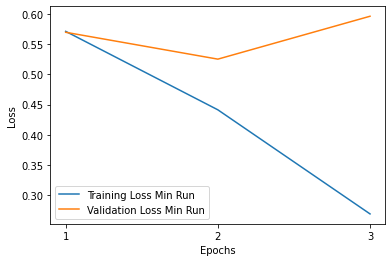

In [15]:
training_loss_min = [0.5717,0.441300,0.2683]
training_loss_max = [0.57460,0.442,0.2661]
val_loss_min = [0.570152,0.525531,0.596814]
val_loss_max = [0.5456659,0.504951,0.583835]
epoch_list=[1,2,3]

plt.figure()
plt.plot(epoch_list,training_loss_min, label="Training Loss Min Run")
plt.plot(epoch_list,val_loss_min, label="Validation Loss Min Run")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epoch_list)
plt.legend()
plt.show()

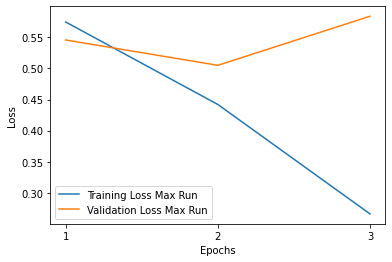

In [16]:
plt.figure()
plt.plot(epoch_list,training_loss_max, label="Training Loss Max Run")
plt.plot(epoch_list,val_loss_max, label="Validation Loss Max Run")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epoch_list)
plt.legend()
plt.show()

eval_loss                      0.518135
eval_accuracy                  0.800687
eval_f1                        0.756091
eval_precision                 0.760613
eval_recall                    0.757113
eval_hate_f1                   0.770281
eval_hate_recall               0.806747
eval_hate_precision            0.739544
eval_offensive_f1              0.870144
eval_offensive_recall          0.873296
eval_offensive_precision       0.867899
eval_normal_f1                 0.627850
eval_normal_recall             0.591295
eval_normal_precision          0.674396
eval_runtime                   3.881660
eval_samples_per_second     1200.504000
eval_steps_per_second         75.257000
epoch                          3.000000
model_run                      5.500000
dtype: float64